# Image model initial evaluation
Se evalúa un modelo de imagen entrenado aplicando las optimizaciones mínimas en la conversión a TensorFlow Lite.
## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from joblib import load
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from image_model_evaluation import COLOR_MODE

## Parámetros

In [2]:
project_dir = "/home/daniel/PycharmProjects/tfg-tinyml"
saved_models_dir = f"{project_dir}/saved models/image"
label_index_dir = f"{saved_models_dir}/label index mappings"
model_name = f"MicroImgDataModel"
model_dir = f"{saved_models_dir}/tensorflow/{model_name}"
test_dir = f"{project_dir}/samples/microcontroller/preprocessed image/test"
show_interval = 1

## Carga del modelo
Cargamos un modelo y mostramos un resumen de su estructura.

In [3]:
model = load_model(model_dir)
model.summary()

class_names = load(f"{label_index_dir}/{model_name}.joblib")
class_indexes = {}
for index, name in enumerate(class_names):
    class_indexes[name] = index

Model: "MicroImgDataModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 96, 96, 1)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 97, 97, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 4)         36        
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 4)         16        
_________________________________________________________________
re_lu (ReLU)                 (None, 48, 48, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 8)         288       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 8)   

## Inferencia
Se realiza inferencia sobre los archivos de la carpeta test y se muestran los resultados.

Testing 23 images from class face.


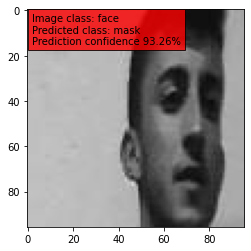

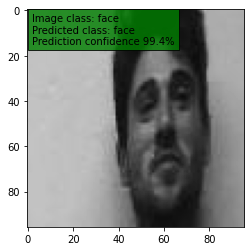

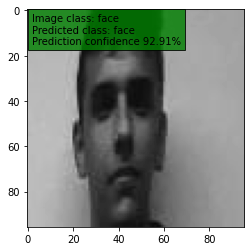

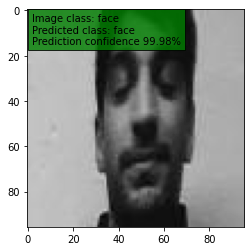

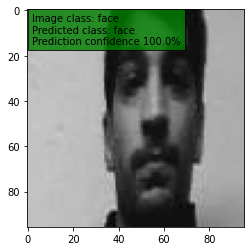

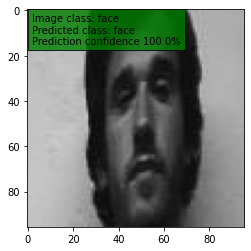

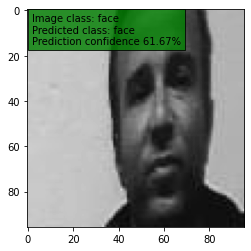

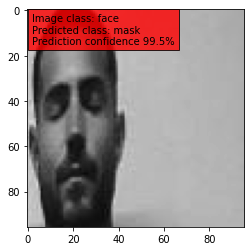

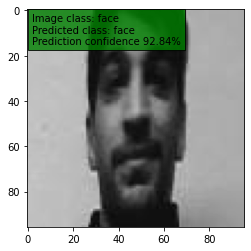

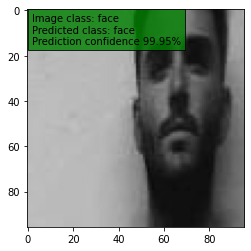

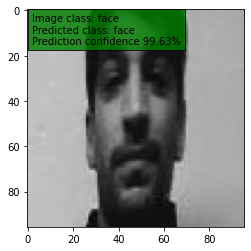

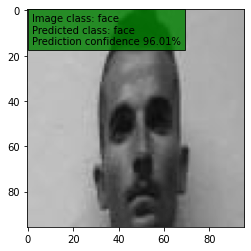

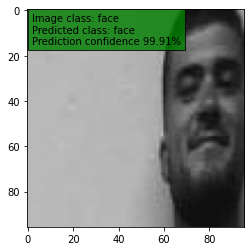

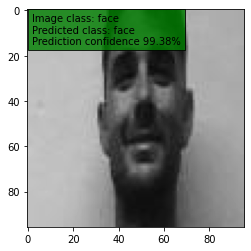

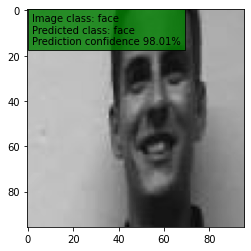

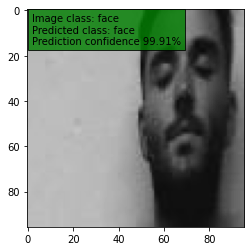

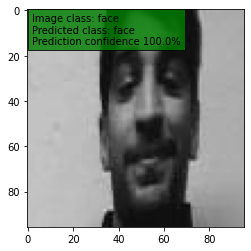

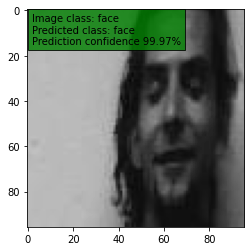

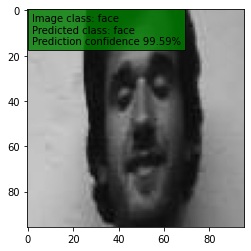

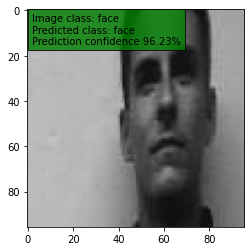

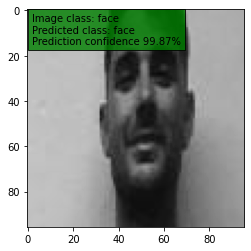

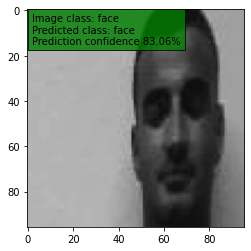

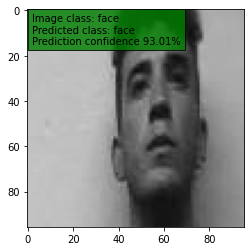

Testing 24 images from class mask.


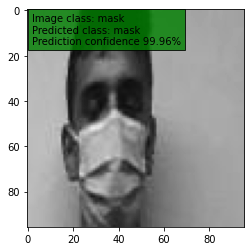

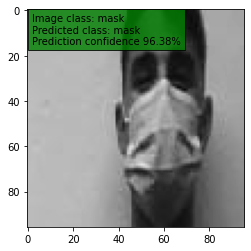

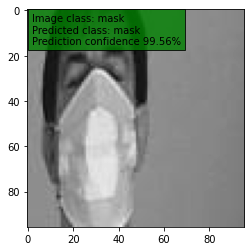

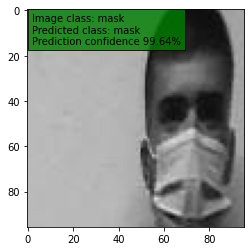

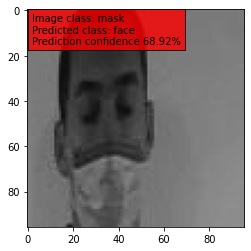

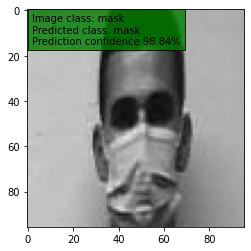

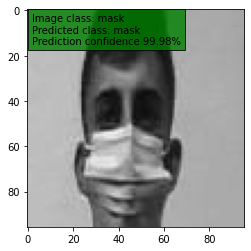

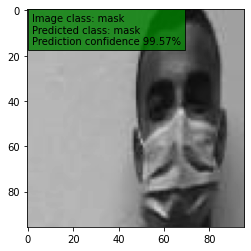

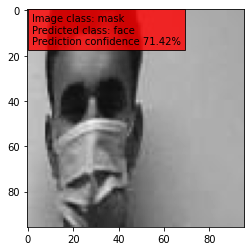

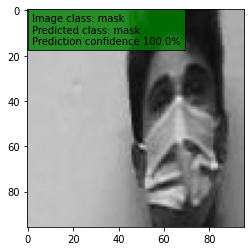

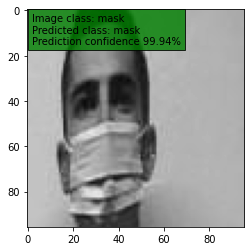

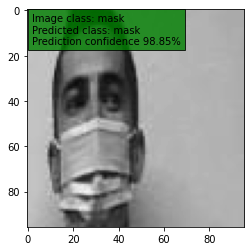

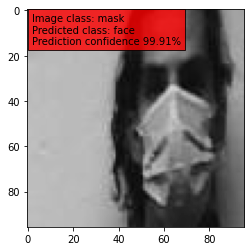

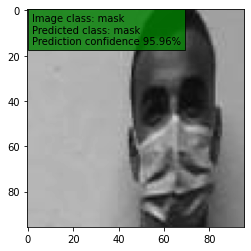

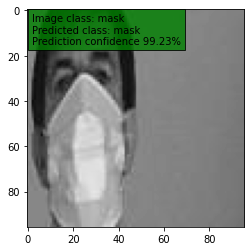

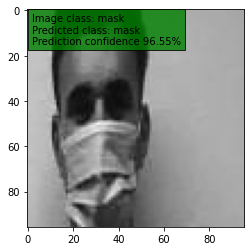

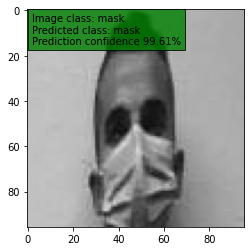

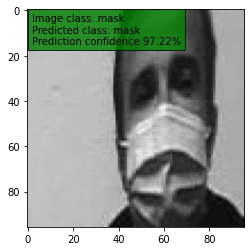

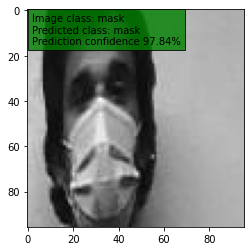

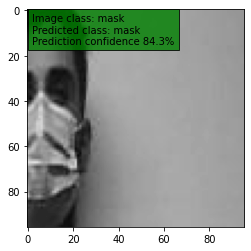

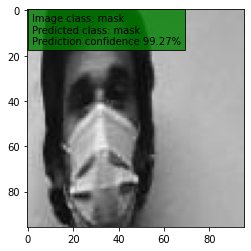

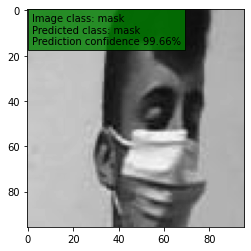

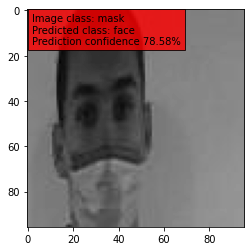

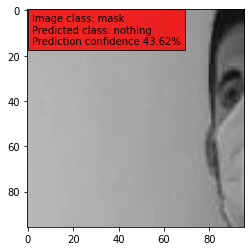

Testing 21 images from class nothing.


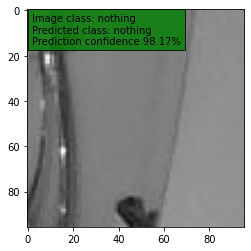

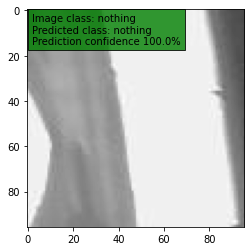

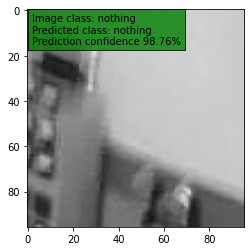

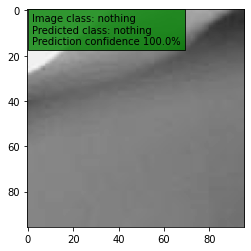

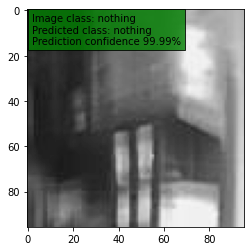

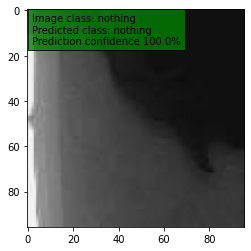

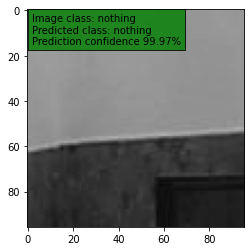

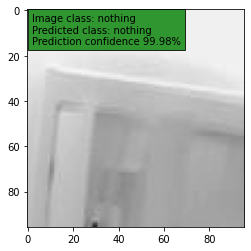

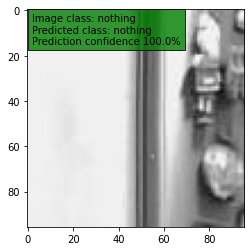

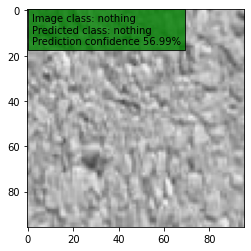

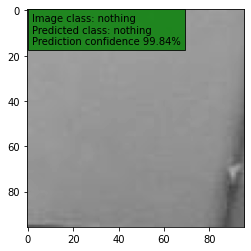

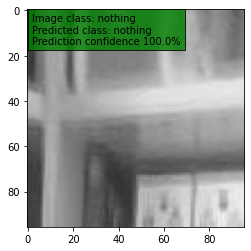

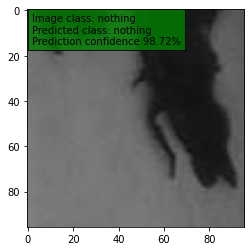

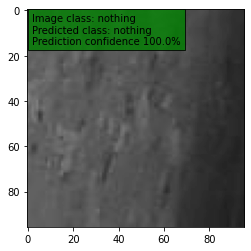

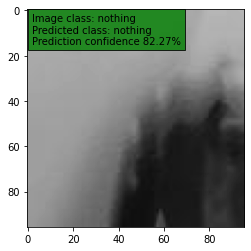

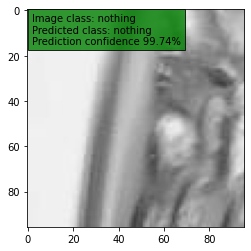

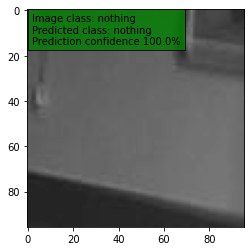

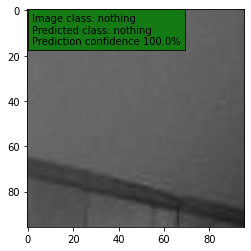

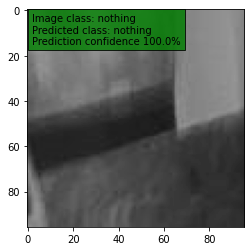

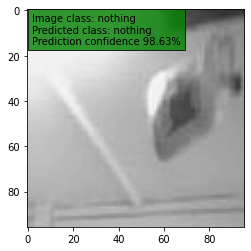

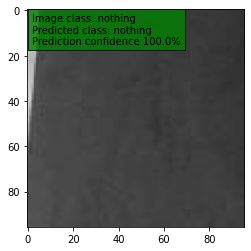

In [4]:
predictions = []
true_labels = []

classes = os.listdir(test_dir)
show_counter = 0

for name in classes:
    class_dir = f"{test_dir}/{name}"
    files = os.listdir(class_dir)
    print(f"Testing {len(files)} images from class {name}.")
    class_index = class_indexes[name]
    for file in files:
        true_labels.append(class_index)

        file_path = f"{test_dir}/{name}/{file}"
        
        img = load_img(file_path, color_mode=COLOR_MODE)
        img_array = img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        prediction = model.predict(img_array)
        score = tf.nn.softmax(prediction[0])

        predicted_class = np.argmax(score)
        predictions.append(predicted_class)
        prediction_score = np.max(score)

        if show_counter % show_interval == 0 or predicted_class != class_index:
            if predicted_class == class_index:
                text_color = "green"
            else:
                text_color = "red"
            plt.figure()
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
            plt.text(2, 15, f"Image class: {name}\nPredicted class: {class_names[predicted_class]}\nPrediction confidence "
                     f"{(prediction_score * 100.).round(2)}%", color="black", bbox=dict(facecolor=text_color, alpha=0.8))
            plt.show()

        show_counter +=1

## Visualización de métricas

Se muestran datos acerca del comportamiento general del modelo al evaluar las muestras.

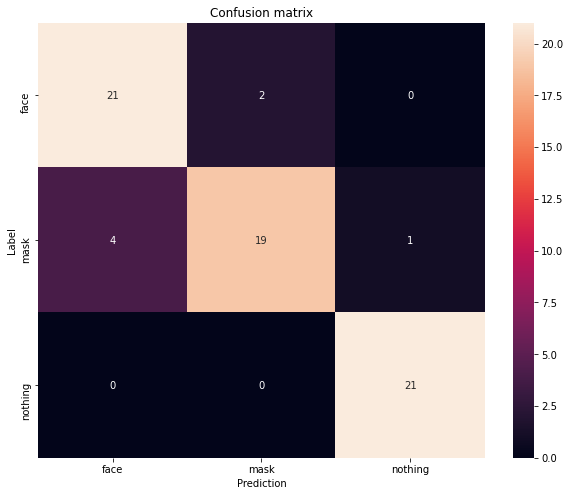

              precision    recall  f1-score   support

        face       0.84      0.91      0.87        23
        mask       0.90      0.79      0.84        24
     nothing       0.95      1.00      0.98        21

    accuracy                           0.90        68
   macro avg       0.90      0.90      0.90        68
weighted avg       0.90      0.90      0.90        68



In [5]:
confusion_mtx = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=class_names, yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title("Confusion matrix")
plt.show()
print(classification_report(true_labels, predictions, target_names=class_names))